In [46]:
printmd('PYTORCH based 5 stages Diabetic Retinopathy detector.')
printmd('1 Self designed Neural Network Model and 1 ResNet18 pretrained-retrained Model')
printmd('Both models trained for over 150 Epochs.')
printmd('Self designed model has the accuracy of 98.00%, and the ResNet model accuracy is 97.14% ')

printmd('1050 Images for training and 350 Images for validation. Each iteration took 6 minutes on CPU.')
printmd('Classification reports, Confusion Matrix and Roc curves with AUC values for all classes')
printmd('Accuracy and Loss plots comparing training and validation performance.')



## <span style="color:brown">PYTORCH based 5 stages Diabetic Retinopathy detector.</span>

## <span style="color:brown">1 Self designed Neural Network Model and 1 ResNet18 pretrained-retrained Model</span>

## <span style="color:brown">Both models trained for over 150 Epochs.</span>

## <span style="color:brown">Self designed model has the accuracy of 98.00%, and the ResNet model accuracy is 97.14% </span>

## <span style="color:brown">1050 Images for training and 350 Images for validation. Each iteration took 6 minutes on CPU.</span>

## <span style="color:brown">Classification reports, Confusion Matrix and Roc curves with AUC values for all classes</span>

## <span style="color:brown">Accuracy and Loss plots comparing training and validation performance.</span>

In [5]:
################################################################################################################################
# Import all modules such as numpy, pandas, matplotlib, seaborn, markdown, display, IPYTHON etc. 
################################################################################################################################
import time
start = time.time()
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import tqdm

import pandas as pd
import seaborn as sns
#sns.set(style='whitegrid', palette='muted', font_scale=1.0)
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score
import os
import subprocess
import copy
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown('## <span style="color:brown">'+string+'</span>'))

In [6]:
################################################################################################################################
# define the target size of the images
################################################################################################################################

H,W=350,350

In [7]:
################################################################################################################################
# Import the modules required for Neural Network building and evaluation
################################################################################################################################

import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision.transforms import ToTensor, Lambda
from torchvision import transforms
import torchvision

from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler


In [8]:
################################################################################################################################
# define paths for the image files and annotation files, also fix the missing files extension for all image files
################################################################################################################################


img_dir = './dataset'
annotations_file = './Train2.csv'
train = pd.read_csv('./Train1.csv')

train["image"] = train["image"].apply(lambda x: x + ".jpeg")
train['level'] = train['level'].astype('str')
train.to_csv('./Train2.csv',index=False)


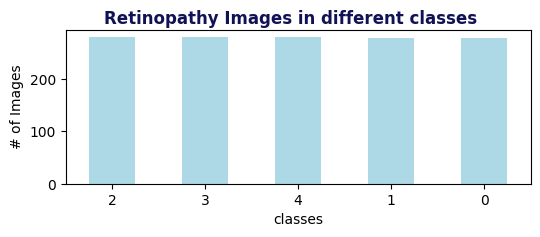

In [9]:
################################################################################################################################
# Verify the labels are evenly distributed among all classes or not
################################################################################################################################
plt.figure(figsize=(6,2))
Vcounts = train['level'].value_counts().plot(kind='bar',color='lightblue')
plt.xlabel('classes')
plt.ylabel('# of Images')
plt.suptitle('Retinopathy Images in different classes',color='#111155',fontweight='bold')  
plt.xticks(rotation=0)
plt.show()

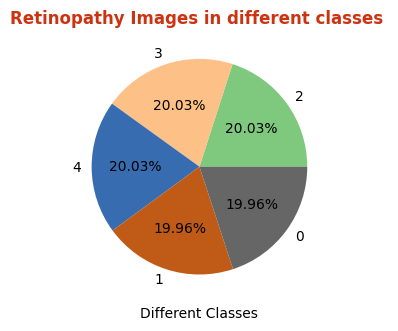

In [10]:
################################################################################################################################
# verify the labels percentage in different classes
################################################################################################################################
plt.figure(figsize=(6,3.5))
Vcounts = train['level'].value_counts().plot(kind='pie',autopct='%.2f%%',colormap='Accent')
plt.xlabel('Different Classes')
plt.ylabel(' ')
plt.title('Retinopathy Images in different classes ',color='#cc3311',fontweight='bold')
plt.show()

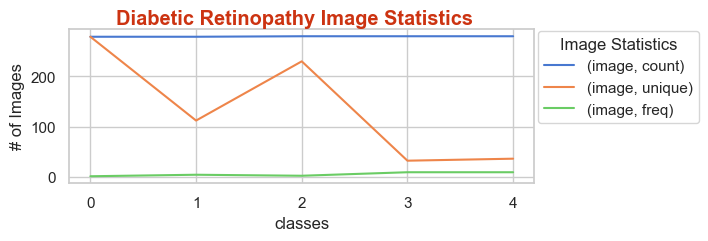

In [11]:
################################################################################################################################
# Image statistics.
################################################################################################################################
sns.set(style='whitegrid', palette='muted', font_scale=1.0)
train.groupby(by='level').describe().plot(kind='line',figsize=(6,2)) 
plt.xticks(range(5))
plt.legend(title='Image Statistics', bbox_to_anchor=(.870, .54, 0.5, 0.5))                                                   
plt.xlabel('classes')
plt.ylabel('# of Images')
plt.suptitle('Diabetic Retinopathy Image Statistics',color='#cc3311',fontweight='bold')
plt.show() 

In [12]:
################################################################################################################################
# check how many classes are there in the file
################################################################################################################################
classes = train['level'].nunique()
classes

5

In [13]:
################################################################################################################################
# define the transforms / just the resize transformation and declare the custome dataset for uploading image and labels
################################################################################################################################ 
transforms = transforms.Compose([transforms.Resize((350,350))]) 
           

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=transforms, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return [image, label]

In [14]:
################################################################################################################################
# extract one set of image and lable to see if the dataest is working ok or not
################################################################################################################################
[image, label] = next(iter(CustomImageDataset(annotations_file=annotations_file, img_dir=img_dir, transform=transforms ))) 

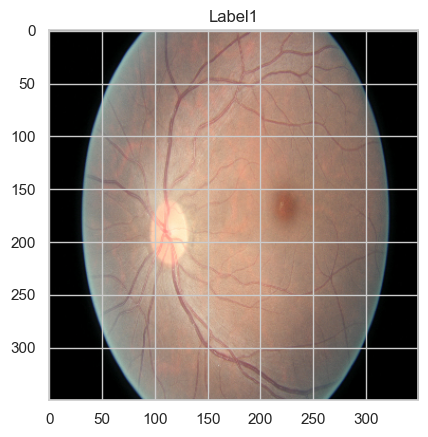

In [15]:
################################################################################################################################
# plot one image and label to verify the dataset/resizing is working fine
################################################################################################################################
plt.imshow(np.transpose(image,(1,2,0)))
plt.title('Label'+str(label))
plt.show()

In [16]:
################################################################################################################################
# extract the whole dataset to see how many images are there in the file
################################################################################################################################
dataset = CustomImageDataset(annotations_file=annotations_file, img_dir=img_dir)

In [17]:
################################################################################################################################
# check the image and/or lables count
################################################################################################################################
dataset.img_labels.count()

image    1398
level    1398
dtype: int64

In [18]:
################################################################################################################################
# split the images into testing and training sets in the ratio of 
################################################################################################################################
indices = torch.randperm(len(dataset)).tolist()
dataset_train = torch.utils.data.Subset(dataset,indices[:-350])
dataset_test  = torch.utils.data.Subset(dataset,indices[-350:])

In [19]:
################################################################################################################################
# check the length of the test file to see its split as declared
################################################################################################################################
len(dataset_test)

350

In [20]:
################################################################################################################################
# define the collate function
################################################################################################################################
def collate_fn(batch):
    return list(zip(*batch))


In [21]:
################################################################################################################################
# declare the training and testing datasets with batch size, shuffling etc.
################################################################################################################################
data_loader_train = torch.utils.data.DataLoader(dataset_train,batch_size=10,shuffle=True,num_workers=0)   
                                              #  collate_fn=collate_fn)

data_loader_test = torch.utils.data.DataLoader(dataset_test,batch_size=10,shuffle=False,num_workers=0)   
                                                #   collate_fn=collate_fn)


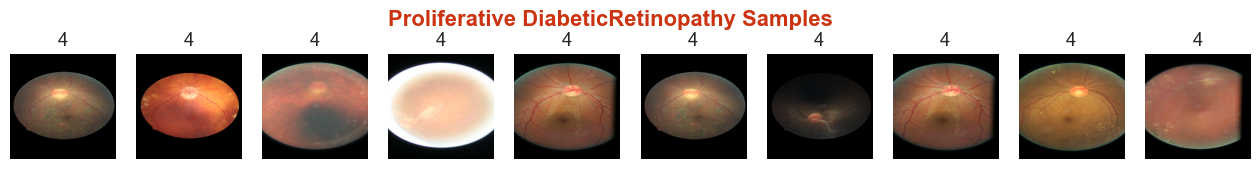

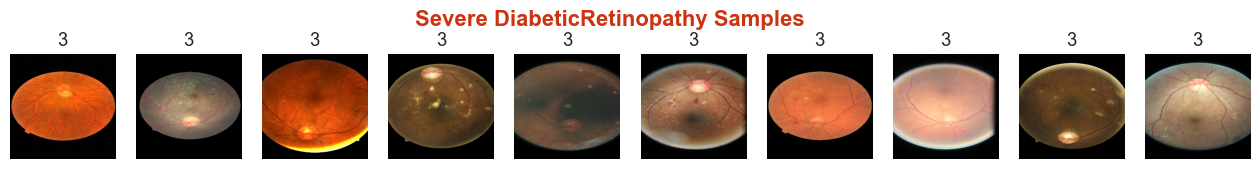

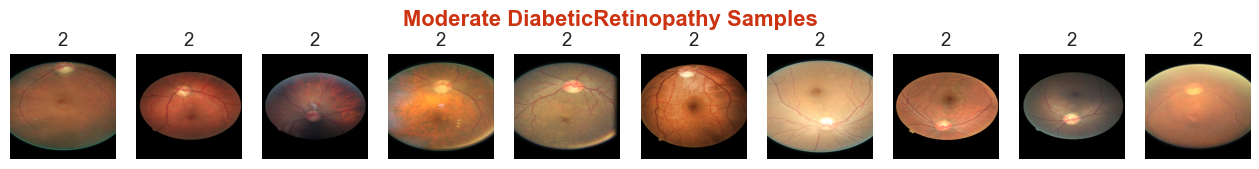

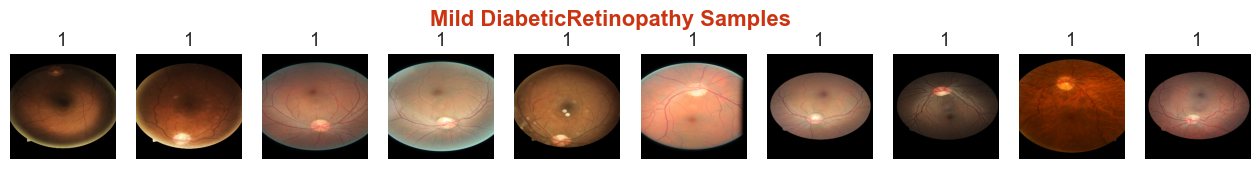

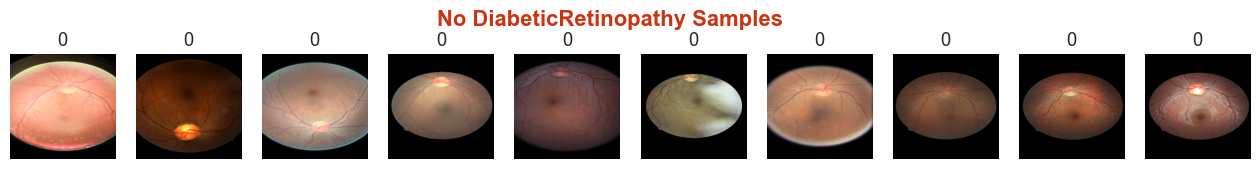

In [22]:
################################################################################################################################
# display 10 images from each of the 5 classes
################################################################################################################################
n_explain = 10

sns.set(style='whitegrid', palette='muted', font_scale=1.1)
plt.figure(figsize=(16, 2))
a=0
for i, [image, label] in enumerate(data_loader_test): 
    if a == n_explain: break
    for j in range(data_loader_test.batch_size):
        if label[j] == 4 and a<n_explain:
            a+=1
            plt.subplot(1, n_explain, a)
            img = np.transpose(image[j],(2,1,0))
            
            plt.imshow(img)
            plt.axis('off')
            plt.title(label[j].item())
        if a == n_explain:
            plt.suptitle("Proliferative DiabeticRetinopathy Samples",color='#cc3311',fontweight='bold')
            plt.show()
            break
plt.figure(figsize=(16, 2))
a=0
for i, [image, label] in enumerate(data_loader_test): 
    if a == n_explain: break
    for j in range(data_loader_test.batch_size):
        if label[j] == 3 and a<n_explain:
            a+=1
            plt.subplot(1, n_explain, a)
            img = np.transpose(image[j],(2,1,0))
    
            plt.imshow(img)
            plt.axis('off')
            plt.title(label[j].item())
        if a == n_explain:
            plt.suptitle("Severe DiabeticRetinopathy Samples",color='#cc3311',fontweight='bold')
            plt.show()
            break
plt.figure(figsize=(16, 2))
a=0
for i, [image, label] in enumerate(data_loader_test): 
    if a == n_explain: break
    for j in range(data_loader_test.batch_size):
        if label[j] == 2 and a<n_explain:
            a+=1
            plt.subplot(1, n_explain, a)
            img = np.transpose(image[j],(2,1,0))
    
            plt.imshow(img)
            plt.axis('off')
            plt.title(label[j].item())
        if a == n_explain:
            plt.suptitle("Moderate DiabeticRetinopathy Samples",color='#cc3311',fontweight='bold')
            plt.show()
            break
plt.figure(figsize=(16, 2))
a=0
for i, [image, label] in enumerate(data_loader_test):
    if a == n_explain: break
    for j in range(data_loader_test.batch_size):
        if label[j] == 1 and a<n_explain:
            a+=1
            plt.subplot(1, n_explain, a)
            img = np.transpose(image[j],(2,1,0))
            
            plt.imshow(img)
            plt.axis('off')
            plt.title(label[j].item())
        if a == n_explain:
            plt.suptitle("Mild DiabeticRetinopathy Samples",color='#cc3311',fontweight='bold')
            plt.show()
            break
plt.figure(figsize=(16, 2))
a=0
for i, [image, label] in enumerate(data_loader_test): 
    if a == n_explain: break
    for j in range(data_loader_test.batch_size):
        if label[j] == 0 and a<n_explain:
            a+=1
            plt.subplot(1, n_explain, a)
            img = np.transpose(image[j],(2,1,0))
            
            plt.imshow(img)
            plt.axis('off')
            plt.title(label[j].item())
        if a == n_explain:
            plt.suptitle("No DiabeticRetinopathy Samples",color='#cc3311',fontweight='bold')
            plt.show()
            break



In [23]:
################################################################################################################################
# define the sequential neural network model and the support functions
################################################################################################################################
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)


def preprocess(x):
    return x.view(-1, 3, 350, 350)

################################################################################################################################
############################## Sequential model      ###########################################################################
################################################################################################################################


def model_create():
    model = nn.Sequential(
        Lambda(preprocess),
        
        nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(64, 5, kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        #nn.AvgPool2d(4),
        Lambda(lambda x: x.view(x.size(0), -1)),
    )
    return model
 

In [24]:
################################################################################################################################
# define the training and evaluation module
################################################################################################################################
def train_model(model, criterion, optimizer, scheduler, weightspath, num_epochs=25,best_acc=0):
    since = time.time()
    TrainLoss = []
    TrainAcc = []
    ValLoss = []
    ValAcc = []

    from tqdm.notebook import tqdm as tqdmTrain
    best_model_wts = copy.deepcopy(model.state_dict())
    print('best_acc ',best_acc)
    for epoch in tqdmTrain(range(num_epochs)):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 125)
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            running_loss = 0.0
            running_corrects = 0
            if phase == 'train':
                model.train()  # Set model to training mode  
                for inputs, labels in data_loader_train: 
                    inputs = inputs.float()
                    inputs = torch.tensor(inputs)
                    labels = torch.tensor(labels)                        

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(True):
                        
                        outputs = model(inputs)
                        a, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)    
                    
                    ##########################################################################
                    # ###############         l1 & l2 regularization   #######################
                    ##########################################################################
                    #l12_lambda = 1e-3
                    #l1_norm = sum(p.abs().sum()    for p in model.parameters())
                    #l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
                    #loss = loss + l12_lambda * l1_norm
                    #loss = loss + l12_lambda * l2_norm
                    ##########################################################################
                    
                    # backward + optimize only if in training phase

                    loss.backward()
                    optimizer.step()
                    
              # epoch/phase level tasks
                
                scheduler.step()
                epoch_loss = running_loss / (len(data_loader_train)*data_loader_train.batch_size)
                epoch_acc = running_corrects / (len(data_loader_train)*data_loader_train.batch_size)
                TrainLoss.append(epoch_loss)
                TrainAcc.append(epoch_acc)

            if phase == 'val': 
                model.eval()   # Set model to evaluate mode
                for inputs, labels in data_loader_test:
                    inputs = inputs.float()
                    inputs = torch.tensor(inputs)
                    labels = torch.tensor(labels) 
                  # zero the parameter gradients
                    optimizer.zero_grad()
                  # forward
                    with torch.set_grad_enabled(False):
                        outputs = model(inputs)
                        a, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                  # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
        
              # epoch/phase level tasks 
                epoch_loss = running_loss / (len(data_loader_test)*data_loader_test.batch_size)
                epoch_acc = running_corrects / (len(data_loader_test)*data_loader_test.batch_size)
                ValLoss.append(epoch_loss)
                ValAcc.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                #torch.save(model.state_dict(), './Weights/model_PYTORCH_RETINOPATHY.pth')
                torch.save(model.state_dict(), weightspath)
                print(' ')
                print('Val Accuracy improved from ', best_acc , ' to ', epoch_acc, ' ', time.ctime() )
                print(' ')
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,[TrainAcc,TrainLoss,ValAcc,ValLoss]

In [25]:
################################################################################################################################
# instantiate the model
################################################################################################################################
model = model_create()

In [28]:
################################################################################################################################
# declare the loss function, optimizer, lr scheduler, weightspath, epochs, lr, l2 norm, betas, best accuracy etc.
################################################################################################################################
criterion = nn.CrossEntropyLoss()   
epochs = 2
weightspath ='./Weights/model_PYTORCH_RETINOPATHY.pth'
optimizer = optim.Adam(model.parameters(), lr=7.6e-05,weight_decay=5e-5,amsgrad=False,betas=(.9,.999)) 
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.95,last_epoch=-1,verbose=True)

model,stat = train_model(model, criterion, optimizer, step_lr_scheduler, weightspath, epochs,best_acc=0.980)

Adjusting learning rate of group 0 to 7.6000e-05.
best_acc  0.974286


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 0/1
-----------------------------------------------------------------------------------------------------------------------------
Adjusting learning rate of group 0 to 7.6000e-05.
train Loss: 0.1235 Acc: 0.9686
val Loss: 0.1303 Acc: 0.9714

Epoch 1/1
-----------------------------------------------------------------------------------------------------------------------------
Adjusting learning rate of group 0 to 7.6000e-05.
train Loss: 0.1069 Acc: 0.9724
val Loss: 0.1224 Acc: 0.9800
 
Val Accuracy improved from  0.974286  to  tensor(0.9800)   Tue Oct 12 20:10:55 2021
 

Training complete in 12m 3s
Best val Acc: 0.980000


In [30]:
################################################################################################################################
# define the weights path and load the weights in a frshly instantiated model
################################################################################################################################
weightspath ='./Weights/model_PYTORCH_RETINOPATHY.pth'

model = model_create()

model.load_state_dict(torch.load(weightspath))


<All keys matched successfully>

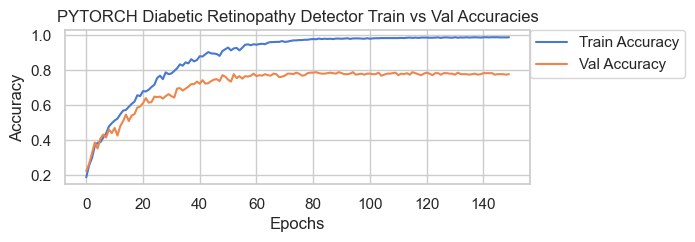

In [523]:
################################################################################################################################
# the below code is for plotting the accuracy curve of training and evaluation captured while training
################################################################################################################################

sns.set(style='whitegrid', palette='muted', font_scale=1.0)
plt.figure(figsize=(6,2))
plt.plot(stat[0], label='Train Accuracy')
plt.plot(stat[2], label='Val Accuracy')
plt.grid(True)
plt.title('PYTORCH Diabetic Retinopathy Detector Train vs Val Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend(bbox_to_anchor=(0.85, .55, 0.5, 0.5))
plt.show()

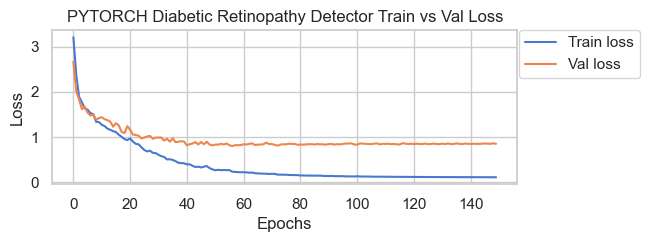

In [524]:
################################################################################################################################
# the below code is for plotting the loss curve of training and evaluation captured while training 
################################################################################################################################
sns.set(style='whitegrid', palette='muted', font_scale=1.0)
plt.figure(figsize=(6,2))
plt.plot(stat[1], label='Train loss')
plt.plot(stat[3], label='Val loss')
plt.title('PYTORCH Diabetic Retinopathy Detector Train vs Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(bbox_to_anchor=(0.78, .55, 0.5, 0.5))
plt.show()

In [32]:
################################################################################################################################
# predict using the model on testing data file, and compute data for confusion matix, classification report and AUC/ROC
################################################################################################################################

Classes = 5
Test_Pred = []
Test_Labels = []


for i, (inputs, labels) in enumerate(data_loader_test):
    inputs = inputs.float()
    inputs = torch.tensor(inputs)
    labels = torch.tensor(labels)
    outputs = model(inputs)
    _, scores = torch.max(outputs, 1)
    Test_Pred.extend(scores.numpy().tolist())
    Test_Labels.extend(labels.numpy().tolist())
  

test_cnfu_matrix = confusion_matrix(Test_Labels, Test_Pred)
labels = ['No DR', 'Mild DR', 'Mod. DR', 'Severe DR', 'Prolif. DR']
test_df_cm  = pd.DataFrame(test_cnfu_matrix,  index=labels, columns=labels)
print(test_df_cm)

            No DR  Mild DR  Mod. DR  Severe DR  Prolif. DR
No DR          59        3        2          1           0
Mild DR         0       65        0          0           0
Mod. DR         1        0       63          0           0
Severe DR       0        0        0         84           0
Prolif. DR      0        0        0          0          72


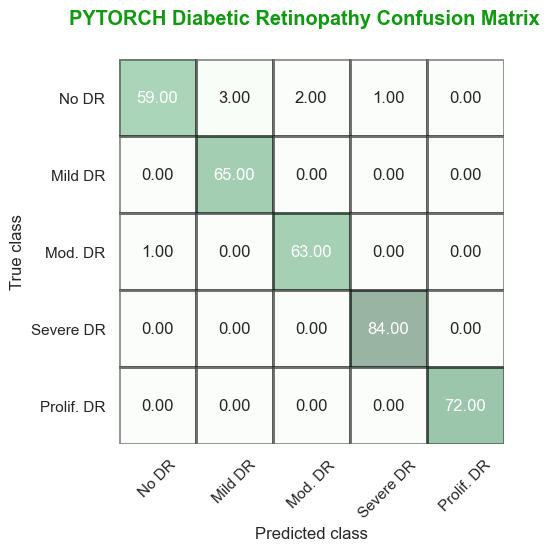

In [33]:
################################################################################################################################
# plot the confusion matrix of testing data predictions  
################################################################################################################################

plt.figure(figsize=(5,5))
sns.set(style='whitegrid', palette='muted', font_scale=1.0)
sns.heatmap(test_df_cm,annot=True,fmt='.2f',linewidths=2,linecolor='black',square=True,cmap=plt.cm.Greens,\
            cbar=False,alpha=.4)
plt.suptitle('PYTORCH Diabetic Retinopathy Confusion Matrix',color='#119911',fontweight='bold')

plt.yticks(rotation=0)
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.xticks(rotation=45)
plt.show()  


In [34]:
################################################################################################################################
# print the classification report with precision, recall and f1-score for Model
################################################################################################################################


print(classification_report(Test_Labels, Test_Pred,target_names=labels))

              precision    recall  f1-score   support

       No DR       0.98      0.91      0.94        65
     Mild DR       0.96      1.00      0.98        65
     Mod. DR       0.97      0.98      0.98        64
   Severe DR       0.99      1.00      0.99        84
  Prolif. DR       1.00      1.00      1.00        72

    accuracy                           0.98       350
   macro avg       0.98      0.98      0.98       350
weighted avg       0.98      0.98      0.98       350



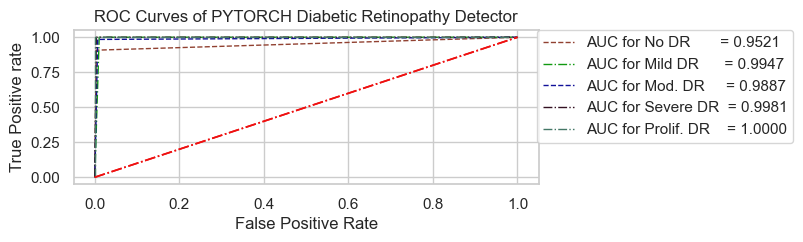

In [35]:
################################################################################################################################
# plot the roc_curve and print the AUC values in it for all the 5 classes of the model.
################################################################################################################################
sns.set(style='whitegrid', palette='muted', font_scale=1.0)
fpr = {}
tpr = {}
thresh = {}
roc_auc = {}
TestLabels = pd.get_dummies(Test_Labels)
TestPred =   pd.get_dummies(Test_Pred)
n_classes = 5
i=0
while i < n_classes:
    fpr[i], tpr[i], thresh[i] = roc_curve(TestLabels.iloc[:,i], TestPred.iloc[:,i])
    i+=1

i=0
while i < n_classes:
    roc_auc[i] = auc(fpr[i], tpr[i])
    i+=1

plt.figure(figsize=(6,2))
plt.plot(fpr[0], tpr[0], linestyle='--',color='#914131',lw=1, label='AUC for No DR       = %0.4f'% roc_auc[0])
plt.plot(fpr[1], tpr[1], linestyle='-.',color='#119911',lw=1, label='AUC for Mild DR      = %0.4f'% roc_auc[1])
plt.plot(fpr[2], tpr[2], linestyle='--',color='#111199',lw=1, label='AUC for Mod. DR     = %0.4f'% roc_auc[2])
plt.plot(fpr[3], tpr[3], linestyle='-.',color='#331122',lw=1, label='AUC for Severe DR  = %0.4f'% roc_auc[3])
plt.plot(fpr[4], tpr[4], linestyle='-.',color='#447766',lw=1, label='AUC for Prolif. DR    = %0.4f'% roc_auc[4])
plt.plot([(0,0),(1,1)],linestyle='-.',color='#ee1111',lw=1.2)


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.title('ROC Curves of PYTORCH Diabetic Retinopathy Detector') 
plt.grid(True)
plt.legend(loc='best', bbox_to_anchor=(0.98, .55, 0.5, 0.5))
plt.show()


In [36]:
################################################################################################################################
# comput the accuracy value with full precision
################################################################################################################################
accuracy_score(Test_Labels, Test_Pred)

0.98

In [37]:
printmd('Accuracy of PYTORCH Retenopathy Detector is : '+str(round((accuracy_score(Test_Labels, Test_Pred)*100),2))+'%')

## <span style="color:brown">Accuracy of PYTORCH Retenopathy Detector is : 98.0%</span>

In [47]:
printmd('Now I train a pretrained RestNet18 model from scratch.')

## <span style="color:brown">Now I train a pretrained RestNet18 model from scratch.</span>

In [40]:
################################################################################################################################
# define the neural network model with custom head and quantized input layers to be used with ResNet18 pre-trained model
################################################################################################################################

from torch import nn

def create_combined_model(model_fe):
  # Step 1. Isolate the feature extractor.
  model_fe_features = nn.Sequential(
    model_fe.quant,  # Quantize the input
    model_fe.conv1,
    model_fe.bn1,
    model_fe.relu,
    model_fe.maxpool,
    model_fe.layer1,
    model_fe.layer2,
    model_fe.layer3,
    model_fe.layer4,
    model_fe.avgpool,
    model_fe.dequant,  # Dequantize the output
  )

  # Step 2. Create a new "head"
  new_head = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(num_ftrs, classes),
  )

  # Step 3. Combine, and don't forget the quant stubs.
  new_model = nn.Sequential(
    model_fe_features,
    nn.Flatten(1),
    new_head,
  )
  return new_model

In [41]:
################################################################################################################################
# creating a model of ResNet18 and  will train the whole network instead of just the head.  notice `quantize=False`                                                                 
################################################################################################################################
import torchvision.models.quantization as models
classes = 5


model = models.resnet18(pretrained=True, progress=True, quantize=False)
num_ftrs = model.fc.in_features
# Step 1
model.train()
model.fuse_model()
# Step 2
model_ft = create_combined_model(model)
model_ft[0].qconfig = torch.quantization.default_qat_qconfig  # Use default QAT configuration
# Step 3
model_ft = torch.quantization.prepare_qat(model_ft, inplace=True)

In [43]:
################################################################################################################################
# here we are setting all layers as trainable
# notice require_grad = true and accuracy starting from very low for epoch 1
# we are training the whole model from scratch
# Note that we are training everything, so the learning rate is lower
# Notice the smaller learning rate
################################################################################################################################
for param in model_ft.parameters():    
     param.requires_grad = True        
                                       
weightspath = './Weights/model_PYTORCH_Retinopathy_resnet18_TrainWholeModel.pth'
            
device='cpu'
model_ft.to(device)  # We can fine-tune on GPU if available

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model_ft.parameters(), lr=1.2796e-05,  weight_decay=0.001,amsgrad=False,betas=(.9,.999))


step_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=0.90,verbose=1)

model_ft_tuned,stat = train_model(model_ft, criterion, optimizer_ft, step_lr_scheduler, weightspath, 
                             num_epochs=5,best_acc=0.971429)   
 

Adjusting learning rate of group 0 to 1.2796e-05.
best_acc  0.8571


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0/4
-----------------------------------------------------------------------------------------------------------------------------
Adjusting learning rate of group 0 to 1.2796e-05.
train Loss: 0.1787 Acc: 0.9505
val Loss: 0.0914 Acc: 0.9714
 
Val Accuracy improved from  0.8571  to  tensor(0.9714)   Tue Oct 12 21:09:47 2021
 

Epoch 1/4
-----------------------------------------------------------------------------------------------------------------------------
Adjusting learning rate of group 0 to 1.2796e-05.
train Loss: 0.0819 Acc: 0.9686
val Loss: 0.0800 Acc: 0.9714

Epoch 2/4
-----------------------------------------------------------------------------------------------------------------------------
Adjusting learning rate of group 0 to 1.1516e-05.
train Loss: 0.0424 Acc: 0.9790
val Loss: 0.1084 Acc: 0.9629

Epoch 3/4
-----------------------------------------------------------------------------------------------------------------------------
Adjusting learning rate of group 0 to

In [48]:
################################################################################################################################
# here we load the weights saved during training into the model
################################################################################################################################
weightspath ='./Weights/model_PYTORCH_Retinopathy_resnet18_TrainWholeModel.pth'

model_ft.load_state_dict(torch.load(weightspath))

<All keys matched successfully>

In [49]:
################################################################################################################################
# converting the model into quantized model after full training
################################################################################################################################

from torch.quantization import convert
model_ft.cpu()

model_quantized_and_trained = convert(model_ft, inplace=False)

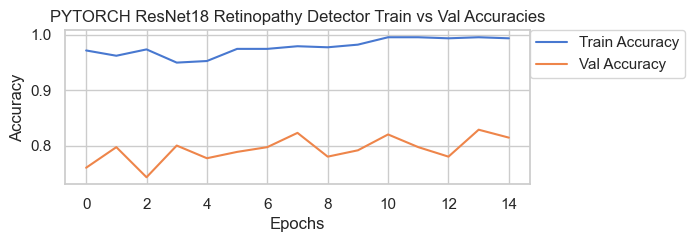

In [93]:
################################################################################################################################
# the below code is for plotting the accuracy curve of training and testing captured while training
################################################################################################################################

sns.set(style='whitegrid', palette='muted', font_scale=1.0)
plt.figure(figsize=(6,2))
plt.plot(stat[0], label='Train Accuracy')
plt.plot(stat[2], label='Val Accuracy')
plt.grid(True)
plt.title("PYTORCH ResNet18 Retinopathy Detector Train vs Val Accuracies")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend(bbox_to_anchor=(0.85, .55, 0.5, 0.5))
plt.show()

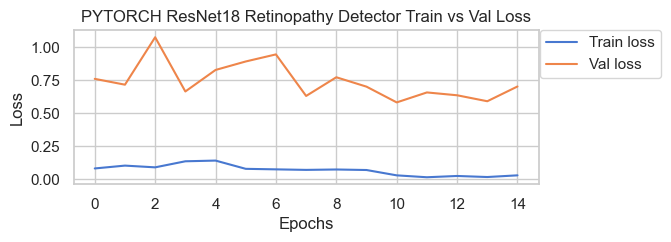

In [94]:
################################################################################################################################
# the below code is for plotting the loss curve of training and testing captured while training 
################################################################################################################################
sns.set(style='whitegrid', palette='muted', font_scale=1.0)
plt.figure(figsize=(6,2))
plt.plot(stat[1], label='Train loss')
plt.plot(stat[3], label='Val loss')
plt.title("PYTORCH ResNet18 Retinopathy Detector Train vs Val Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(bbox_to_anchor=(0.78, .55, 0.5, 0.5))
plt.show()

In [50]:
################################################################################################################################
# predict using the model on testing data file, and compute data for confusion matix, classification report and AUC/ROC values
################################################################################################################################

Classes = 5
Test_Pred = []
Test_Labels = []


for i, (inputs, labels) in enumerate(data_loader_test):
    inputs = inputs.float()
    inputs = torch.tensor(inputs)
    labels = torch.tensor(labels)
    outputs = model_ft(inputs)
    _, scores = torch.max(outputs, 1)
    Test_Pred.extend(scores.numpy().tolist())
    Test_Labels.extend(labels.numpy().tolist())
  

test_cnfu_matrix = confusion_matrix(Test_Labels, Test_Pred)
labels = ['No DR', 'Mild DR', 'Mod. DR', 'Severe DR', 'Prolif. DR']
test_df_cm  = pd.DataFrame(test_cnfu_matrix,  index=labels, columns=labels)
print(test_df_cm)

            No DR  Mild DR  Mod. DR  Severe DR  Prolif. DR
No DR          61        0        4          0           0
Mild DR         0       65        0          0           0
Mod. DR         6        0       58          0           0
Severe DR       0        0        0         84           0
Prolif. DR      0        0        0          0          72


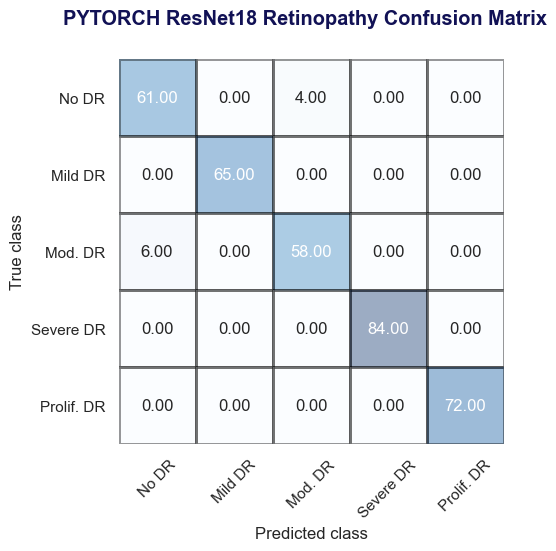

In [51]:
################################################################################################################################
# plot the confusion matrix of testing data predictions  
################################################################################################################################

plt.figure(figsize=(5,5))
sns.set(style='whitegrid', palette='muted', font_scale=1.0)
sns.heatmap(test_df_cm,annot=True,fmt='.2f',linewidths=2,linecolor='black',square=True,cmap=plt.cm.Blues,\
            cbar=False,alpha=.4)
plt.suptitle('PYTORCH ResNet18 Retinopathy Confusion Matrix',color='#111155',fontweight='bold')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()  


In [52]:
################################################################################################################################
# print the classification report with precision, recall and f1-score for all classes of the Model
################################################################################################################################
print(classification_report(Test_Labels, Test_Pred,target_names=labels))


              precision    recall  f1-score   support

       No DR       0.91      0.94      0.92        65
     Mild DR       1.00      1.00      1.00        65
     Mod. DR       0.94      0.91      0.92        64
   Severe DR       1.00      1.00      1.00        84
  Prolif. DR       1.00      1.00      1.00        72

    accuracy                           0.97       350
   macro avg       0.97      0.97      0.97       350
weighted avg       0.97      0.97      0.97       350



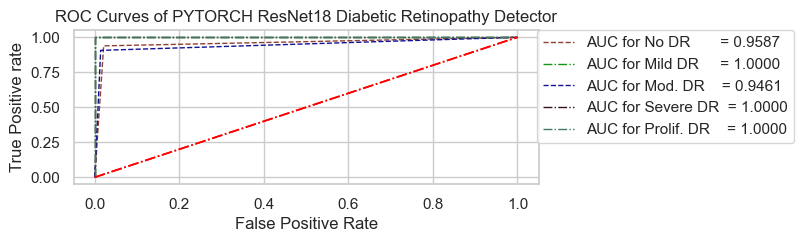

In [53]:
################################################################################################################################
# plot the roc_curve and print the AUC values in it for all the 5 classes in the data
################################################################################################################################
sns.set(style='whitegrid', palette='muted', font_scale=1.0)
fpr = {}
tpr = {}
thresh = {}
roc_auc = {}
TestLabels = pd.get_dummies(Test_Labels)
TestPred =   pd.get_dummies(Test_Pred)
n_classes = 5
i=0
while i < n_classes:
    fpr[i], tpr[i], thresh[i] = roc_curve(TestLabels.iloc[:,i], TestPred.iloc[:,i])
    i+=1

i=0
while i < n_classes:
    roc_auc[i] = auc(fpr[i], tpr[i])
    i+=1

plt.figure(figsize=(6,2))
plt.plot(fpr[0], tpr[0], linestyle='--',color='#914131',lw=1, label='AUC for No DR       = %0.4f'% roc_auc[0])
plt.plot(fpr[1], tpr[1], linestyle='-.',color='#119911',lw=1, label='AUC for Mild DR     = %0.4f'% roc_auc[1])
plt.plot(fpr[2], tpr[2], linestyle='--',color='#111199',lw=1, label='AUC for Mod. DR    = %0.4f'% roc_auc[2])
plt.plot(fpr[3], tpr[3], linestyle='-.',color='#331122',lw=1, label='AUC for Severe DR  = %0.4f'% roc_auc[3])
plt.plot(fpr[4], tpr[4], linestyle='-.',color='#447766',lw=1, label='AUC for Prolif. DR    = %0.4f'% roc_auc[4])
plt.plot([(0,0),(1,1)],linestyle='-.',color='red',lw=1.2)


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.title('ROC Curves of PYTORCH ResNet18 Diabetic Retinopathy Detector') 
plt.grid(True)
plt.legend(loc='best', bbox_to_anchor=(.98, .55, 0.5, 0.5))
plt.show()


In [55]:
printmd('Accuracy of the ResNet18 model is 97.14%; little less than the self designed model.')

## <span style="color:brown">Accuracy of the ResNet18 model is 97.14%; little less than the self designed model.</span>